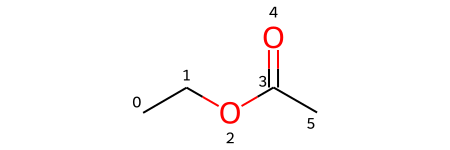

In [30]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdCoordGen
from rdkit.Chem import Draw
from rdkit.Chem import rdchem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True

molecule_name = 'Harvey last'
stringWithMolData=open(f'./OUTPUT/imp_{molecule_name}.nmredata.sdf','r').read()
mol = Chem.MolFromMolBlock(stringWithMolData)
worked = Chem.SDMolSupplier(f'./OUTPUT/imp_{molecule_name}_conf_0.nmredata.sdf', removeHs=False)
m=worked[0]
rdCoordGen.AddCoords(mol)
display(mol)
#mol_img = Draw.MolToImage(mol, includeAtomNumbers=True)
#display(mol_img)
x1 = m.GetProp('NMREDATA_ASSIGNMENT')

x = x1.replace('\\', '')
dfx=pd.DataFrame([x.split(',') for x in x.split('\n')], columns = ['index', 'Shift', 'Atomic_number', 'J split'])
dfx = dfx.applymap(lambda x: x.strip() if isinstance(x, str) else x)
dfx['Atomic_number'] = dfx['Atomic_number'].astype(int)
df_H = dfx[dfx['Atomic_number']==1]
df_C = dfx[dfx['Atomic_number']==6]
df_rest = dfx[~dfx['Atomic_number'].isin([1, 6])]
atoms = [df_H, df_C, df_rest]

In [31]:
x1 = m.GetProp('NMREDATA_J')

x = x1.replace('\\', '')
dfx1=pd.DataFrame([x.split(',') for x in x.split('\n')], columns = ['atom_1', 'atom_2', 'Coupling', 'Correlation', 'empty'])
dfx1 = dfx1.applymap(lambda x: x.strip() if isinstance(x, str) else x)

dfx1[['atom_1', 'atom_2']] = dfx1[['atom_1', 'atom_2']].astype(int)


In [36]:
selected_rows = dfx1[dfx1["atom_2"] == 0]
selected_rows

,atom_1,atom_2,Coupling,Correlation,empty


In [35]:
import os
import pandas as pd
from pylatex import Document, Section, Subsection, Tabular

molecule_name = "EtOAc"
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
dir_name = os.path.splitext(molecule_name)[0]  # remove the file extension from the PNG file name
os.makedirs(dir_name, exist_ok=True)  # create the directory if it doesn't exist
rdCoordGen.AddCoords(m)
d = rdMolDraw2D.MolDraw2DCairo(250, 200) # or MolDraw2DSVG to get SVGs
d.drawOptions().addAtomIndices = True
d.DrawMolecule(m)
d.FinishDrawing()
d.WriteDrawingText(f'./{molecule_name}/{molecule_name}.png')  




# Export df_H to a CSV file named Hydrogen_shifts.csv
df_H.to_csv(f'./{molecule_name}/Hydrogen_shifts.csv', index=False)

# Export df_C to a CSV file named Carbon_shifts.csv
df_C.to_csv(f'./{molecule_name}/Carbon_shifts.csv', index=False)

# Export df_rest to a CSV file named rest_shifts.csv
df_rest.to_csv(f'./{molecule_name}/rest_shifts.csv', index=False)

# Export dfx1 to a CSV file named J_couplings.csv
dfx1.to_csv(f'./{molecule_name}/J_couplings.csv', index=False)



In [39]:

# Group the dataframe by the 'Correlation' column
groups = dfx1.groupby('Correlation')

# Create a dictionary to store the new columns
new_cols = {}

# Loop over each group
for name, group in groups:
    # Create a new column header from the 'Correlation' value
    col_name = name.replace(' ', '_')
    
    # Loop over each row in the group
    for i, row in group.iterrows():
        print(i)
        print(row)
        # Get the atom indices for the coupling
        atom1 = row['atom_1']
        atom2 = row['atom_2']
        
        # Find the row in the main dataframe with the corresponding atom index
        match1 = df_H[df_H['atom_index'] == atom1]
        match2 = df_H[df_H['atom_index'] == atom2]
        
        # Get the corresponding coupling values
        coupling1 = row['Coupling']
        coupling2 = row['Coupling']
        
        # Check which atom index matches the one in the coupling data
        if match1.empty:
            new_col_val = (atom1, coupling2)
        else:
            new_col_val = (atom2, coupling1)
        
        # Add the new column value to the dictionary
        if col_name in new_cols:
            new_cols[col_name].append(new_col_val)
        else:
            new_cols[col_name] = [new_col_val]

# Convert the dictionary to a dataframe and merge it with the original dataframe
new_df = pd.DataFrame(new_cols)
df = pd.merge(dfx1, new_df, left_on='atom_index', right_on=new_df.columns, how='left')

# Drop the columns we don't need anymore
df.drop(['atom_1', 'atom_2', 'empty'], axis=1, inplace=True)
